# Churn prediction

In [1]:
path = 'C:/Users/Paul/Desktop/MSc DSBA/4. Machine Learning/Kaggle Competition'
from os import listdir 
print(listdir(path+ '/Datasets'))

['age_gender_bkts.csv', 'countries.csv', 'sample_submission_NDF.csv', 'sessions.csv', 'test_users.csv', 'train_users_2.csv']


### Data information

#### train_users.csv - the training set of users
#### test_users.csv - the test set of users
        id: user id
        date_account_created: the date of account creation
        timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
        date_first_booking: date of first booking
        gender
        age
        signup_method
        signup_flow: the page a user came to signup up from
        language: international language preference
        affiliate_channel: what kind of paid marketing
        affiliate_provider: where the marketing is e.g. google, craigslist, other
        first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
        signup_app
        first_device_type
        first_browser
        country_destination: this is the target variable you are to predict
#### sessions.csv - web sessions log for users
        user_id: to be joined with the column 'id' in users table
        action
        action_type
        action_detail
        device_type
        secs_elapsed
#### countries.csv - summary statistics of destination countries in this dataset and their locations
#### age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
#### sample_submission.csv - correct format for submitting your predictions

## Importing packages

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Loading datasets

In [3]:
age_gender = pd.read_csv(path + '/Datasets/age_gender_bkts.csv')

In [4]:
countries = pd.read_csv(path + '/Datasets/countries.csv')

In [5]:
sessions = pd.read_csv(path + '/Datasets/sessions.csv')

In [6]:
train = pd.read_csv(path + '/Datasets/train_users_2.csv', index_col=0)

In [7]:
test =  pd.read_csv(path + '/Datasets/test_users.csv')

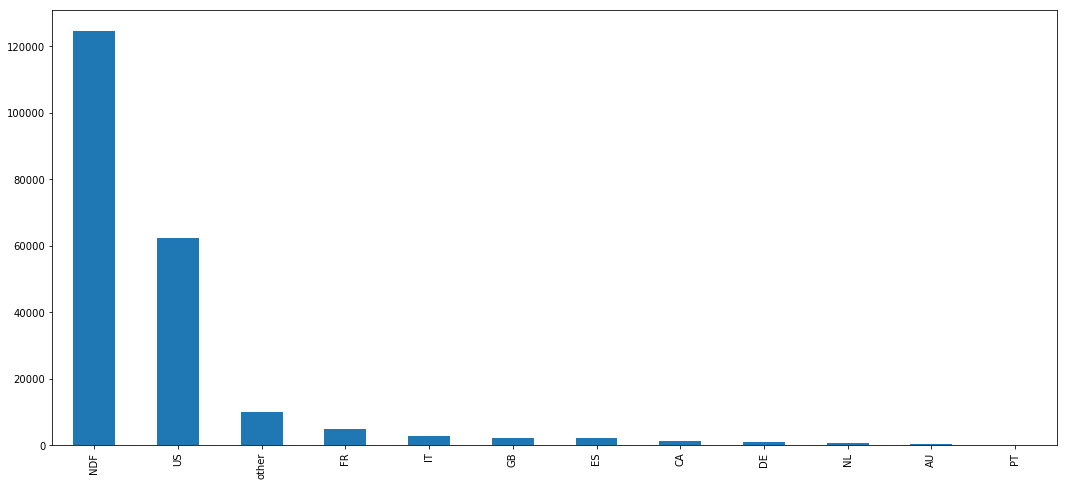

In [8]:
plt.figure(figsize = (18,8))
train.country_destination.value_counts().plot(kind = 'bar')
plt.show()

In [9]:
# sample_submission = pd.read_csv(path + '/Datasets/sample_submission_NDF.csv')

In [10]:
def format_date_variables(data):
    data['date_account_created'] = pd.to_datetime(data['date_account_created'], format = '%Y-%m-%d')
    data['date_first_booking'] = pd.to_datetime(data['date_first_booking'], format = '%Y-%m-%d')
    data['timestamp_first_active'] = data['timestamp_first_active'].apply(lambda x : 
                                                                            str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8])
    data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], format = '%Y-%m-%d')
    
    return data

In [11]:
train = format_date_variables(train)

In [12]:
def aggregate_variables(data, 
                        aggregating_variable = ['id'],
                        aggregating_function = sum, 
                        chunksize = 10000, 
                        verbose = 1):
    
    # Preparing the sessions data
    column_names = ['action', 'action_type', 'action_detail', 'device_type']
    data['id'] = data['user_id']
    
    steps = int(data.shape[0]/chunksize)+1
    if verbose >= 1 :
        print('Number of steps : {}'.format(steps))
    
    list_of_data_sets = []   
    
    for i in range(steps):
        # Print the number of the step
        if verbose == 1:
            print('Step '+str(i+1)+'/'+str(steps))
            
        # making small chunks of data
        data_temp = data.iloc[i*chunksize:(i+1)*chunksize, :]
        ids = data_temp.loc[:,aggregating_variable]
        
        dummies = []
        
        for col in column_names:
            dummies.append(pd.get_dummies(data_temp[col], prefix = col, dummy_na=True))
            
        data_temp = pd.concat([pd.concat(dummies), ids], axis=0)
        if np.random.uniform()>.999:
            print(data_temp.head())
        
        data_agg = data_temp.groupby(aggregating_variable).sum()
        
        #data_agg = data_agg.reset_index(drop = False)
        list_of_data_sets.append(data_agg)
    
    # get the latest chunk and treat it
    data_temp = data.iloc[i*chunksize:,:]
    ids = data_temp.loc[:,aggregating_variable]
    dummies = []
        
    for col in column_names:
        dummies.append(pd.get_dummies(data_temp[col], prefix = col, dummy_na=True))
    
    data_temp = pd.concat([pd.concat(dummies), ids], axis=0, ignore_index = True)

    data_agg = data_temp.groupby(aggregating_variable).sum()
    #data_agg = data_agg.reset_index(drop = False)    
    list_of_data_sets.append(data_agg)  
    
    # Concatenating every chunks
    data_final = pd.concat(list_of_data_sets, axis = 1)
    column_final_names = list(data_final.columns)
    data_final = data_final.reset_index()

    print(column_final_names)
    
    #for i in aggregating_variable:
        #column_final_names.remove(i)
    print(data_final.head())
    
    data_final = data_final.groupby(aggregating_variable)[column_final_names].sum()
    
    return data_final

In [13]:
def plot_features(data = train, feature = 'first_browser', target_feature = 'country_destination', normalize = 0):
    
    mat = pd.crosstab(data[feature], data[target_feature], normalize=normalize)
    mat.plot(kind = 'bar', figsize = (18,8))
    plt.matshow(mat)
    plt.xticks(range(len(mat.columns)), mat.columns)
    plt.yticks(range(len(mat.index)), mat.index)
    plt.title(feature)
    plt.show()
    return mat
    

In [14]:
#train_without_dnf = train[train['country_destination']!='NDF']
#for col in train.columns[:-1] :
#    print(col)
#    if train[col].dtype == object:
#        plot_features(data = train_without_dnf, feature = col, target_feature = 'country_destination', normalize=1)

### Study of age variable

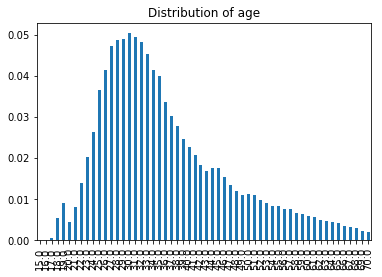

In [15]:
# We can assume that people over 70 are not very likely to use Airbnb
# So their age must be wrong
train.loc[train['age']>70,'age'] = np.NAN
# We can assume that people under 15 are not leggally allowed to uuse Airbnb
train.loc[train['age']<15,'age'] = np.NAN

age_distribution = train.age.value_counts(normalize=1).sort_index()

age_distribution.plot(kind = 'bar')
plt.title('Distribution of age')
plt.show()

In [16]:
# We define as reliable age an age that is between 15 and 70
train['age_as_reliable'] = pd.notnull(train.age)

# Computing mean and std of reliable age
age_avg = np.mean(train.age[train.age_as_reliable])
age_std = np.std(train.age[train.age_as_reliable])

print('== RELIABLE AGE ==')
print('People with reliable age : {}%'.format(round(sum(train['age_as_reliable'])/train.shape[0]*100, 2)))
print('Mean and std of reliable age : {} +/- {}'.format(round(age_avg, 2), round(age_std,2)))


== RELIABLE AGE ==
People with reliable age : 56.97%
Mean and std of reliable age : 36.06 +/- 10.77


### Study of sessions

In [17]:
for col in ['action', 'action_type', 'action_detail', 'device_type']:
    sessions[col] = sessions[col].astype('category')

In [55]:
times = sessions[['user_id', 'secs_elapsed']]

In [56]:
times_agg = times.groupby(['user_id']).agg({'secs_elapsed':['min', 'max', 'median', 'mean', 'count']})

In [59]:
times_agg.columns = times_agg.columns.droplevel()

In [60]:
times_agg.columns = np.array('time_') + times_agg.columns

In [100]:
times_agg = times_agg.reset_index()